<h2> Loading Amanzon Fine Food Reviews Data </h2>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import nltk
import string
import seaborn
import re
import string as sns  # Tutorial about Python regular expressions: https://pymotw.com/2/re/
import pickle
import os
import nltk
import gensim
from gensim.models import word2vec
from gensim.models import keyedvectors

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter 
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm



C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<h2> Reading The Data </h2>

In [4]:
knn_ar = pd.read_csv('Reviews.csv', nrows=50000)
knn_ar.shape

(50000, 10)

In [5]:
knn_ar.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [6]:
def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = knn_ar['Score']
positiveNegative = actualScore.map(partition) 
knn_ar['Score'] = positiveNegative
print("Number of data points in our data", knn_ar.shape)

Number of data points in our data (50000, 10)


In [7]:
knn_ar.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


<h2> Data Cleaning:- Duplication </h2>

In [8]:
sorted_data = knn_ar.sort_values('ProductId', axis=0, ascending=True)
sorted_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
24749,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
24750,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
2773,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2774,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...


In [9]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape

(46268, 10)

In [10]:
(final['Id'].size*1.0)/(knn_ar['Id'].size*1.0)*100

92.536

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
print(final.shape)
final['Score'].value_counts()

(46267, 10)


1    39278
0     6989
Name: Score, dtype: int64

<h2> Spliting The Data Into Train And Test </h2>

In [13]:
x = knn_ar['Text'].values
y= knn_ar['Score'].values

<h2> BOW featurezation  </h2>

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train) 
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(22445,) (22445,)
(11055,) (11055,)
(16500,) (16500,)
After vectorizations
(22445, 28194) (22445,)
(11055, 28194) (11055,)
(16500, 28194) (16500,)


<h2> Applying KNN-BruteFocre </h2>

In [15]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_bow, y_train) 
KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
print(neigh.predict(X_train_bow))
print(neigh.predict_proba(X_train_bow))

[1 1 1 ... 1 1 1]
[[0.         1.        ]
 [0.33333333 0.66666667]
 [0.         1.        ]
 ...
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.         1.        ]]


<h2> Hyper Parameter Tuning (Best K) </h2>

In [16]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]} 

gsv = GridSearchCV(knn,param_grid,verbose=1)
gsv.fit(X_train_bow,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 15.3min finished


Best HyperParameter:  {'n_neighbors': 13}
Best Accuracy: 85.30%


<h2> Performance Of Model </h2>

<h2> Trian Data </h2>

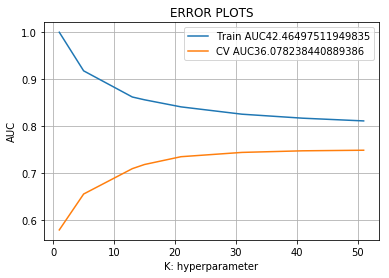

In [17]:
#took this code from assignmesnt_SAMPLE_SOLUTION
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_bow, y_train)
    
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.axis('tight')
plt.grid()
plt.title("ERROR PLOTS")
plt.show()


<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

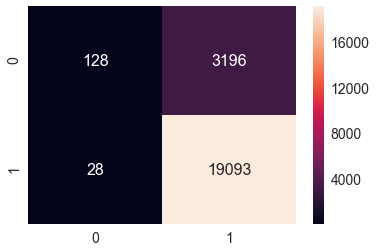

In [94]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Re20KNNviews%20-%%20.ipynb
import seaborn as sns
knn = KNeighborsClassifier(n_neighbors=13)#knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_bow,y_train)
y_pred = knn.predict(X_train_bow)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

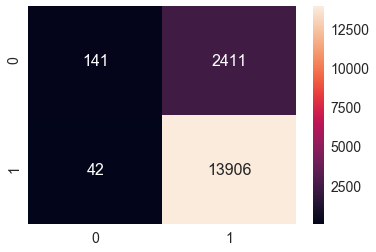

In [95]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_test_bow,y_test)
y_pred = knn.predict(X_test_bow)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

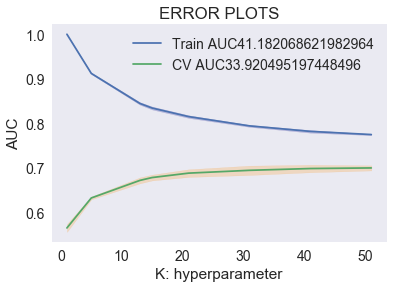

In [19]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_cv_bow, y_cv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<h2> Test Data </h2>

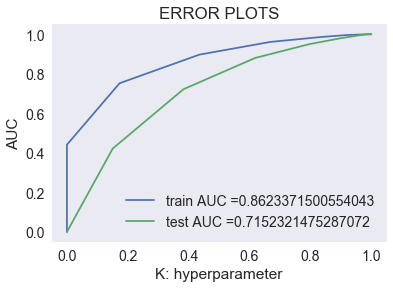

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
best_k = 13
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_bow, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

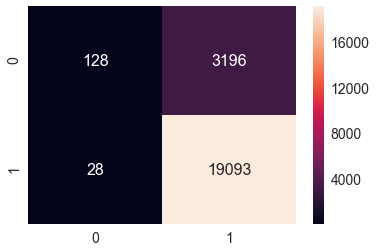

In [96]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_bow,y_train)
y_pred = knn.predict(X_train_bow)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

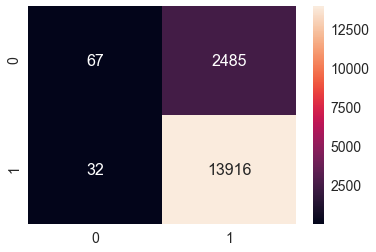

In [97]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_bow,y_train)
y_pred = knn.predict(X_test_bow)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> For KD_TREE </h2>

In [21]:
knn_ar_1 = pd.read_csv('Reviews.csv', nrows=20000)
knn_ar_1.shape

(20000, 10)

In [22]:
def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = knn_ar_1['Score']
positiveNegative = actualScore.map(partition) 
knn_ar_1['Score'] = positiveNegative
print("Number of data points in our data", knn_ar_1.shape)

Number of data points in our data (20000, 10)


In [23]:
knn_ar_1.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


<h2> Spliting The Data Into Train And Test </h2>

In [24]:
e = knn_ar['Text'].values
f = knn_ar['Score'].values

In [25]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(e, f, test_size=0.33) 
X_train_1, X_cv_1, y_train_1, y_cv_1 = train_test_split(X_train_1, y_train_1, test_size=0.33)

print(X_train_1.shape, y_train_1.shape)
print(X_cv_1.shape, y_cv_1.shape)
print(X_test_1.shape, y_test_1.shape)
print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10, max_features= 500)
vectorizer.fit(X_train)

X_train_bow_1= vectorizer.transform(X_train_1)
X_cv_bow_1 = vectorizer.transform(X_cv_1)
X_test_bow_1 = vectorizer.transform(X_test_1)

print("After vectorizations")
print(X_train_bow_1.shape, y_train_1.shape)
print(X_cv_bow_1.shape, y_cv_1.shape)
print(X_test_bow_1.shape, y_test_1.shape)
print("="*100)

(22445,) (22445,)
(11055,) (11055,)
(16500,) (16500,)
After vectorizations
(22445, 500) (22445,)
(11055, 500) (11055,)
(16500, 500) (16500,)


<h2> Applying KNN_kd_tree </h2>

In [26]:
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(X_train_bow_1, y_train_1) 

KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

print(neigh.predict(X_train_bow_1))

print(neigh.predict_proba(X_train_bow_1))

[1 1 1 ... 1 1 1]
[[0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 ...
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.33333333 0.66666667]]


<h2> The Hyper Parameter Tuning (Best k) </h2>

In [27]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]} 
gsv = GridSearchCV(knn,param_grid,verbose=1)
gsv.fit(X_train_bow_1,y_train_1)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("c

Best HyperParameter:  {'n_neighbors': 15}
Best Accuracy: 85.03%


<h2> Performance Of Model </h2>

<h2> Train Data </h2>

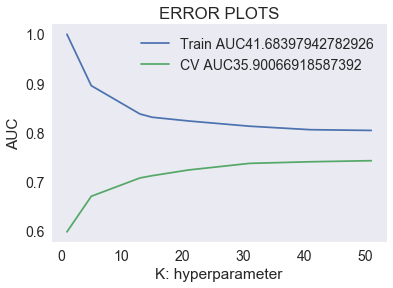

In [28]:
#take this code from assignmesnt_SAMPLE_SOLUTION
train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_bow_1, y_train_1)
    
    y_train_pred =  neigh.predict_proba(X_train_bow_1)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow_1)[:,1]
    
    train_auc.append(roc_auc_score(y_train_1,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_1, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.axis('tight')
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

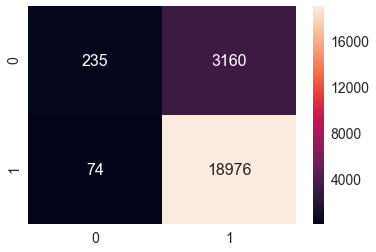

In [90]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_bow_1,y_train_1)
y_pred = knn.predict(X_train_bow_1)

cm = pd.DataFrame(confusion_matrix(y_train_1, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

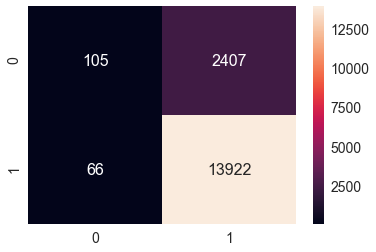

In [91]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_bow_1,y_train_1)
y_pred = knn.predict(X_test_bow_1)

cm = pd.DataFrame(confusion_matrix(y_test_1, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

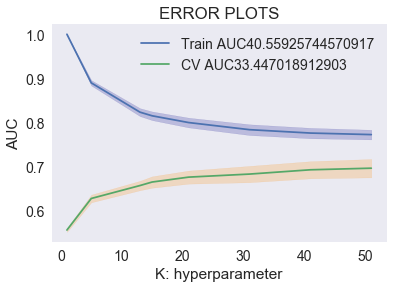

In [29]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_cv_bow_1, y_cv_1)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<h2> Test Data </h2>

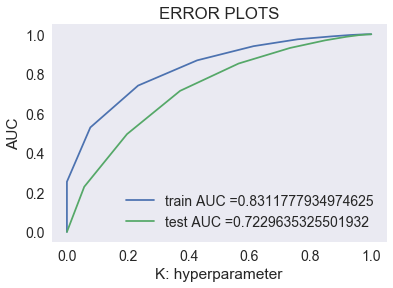

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
best_k = 15
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_bow_1, y_train_1)

train_fpr, train_tpr, thresholds = roc_curve(y_train_1, neigh.predict_proba(X_train_bow_1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_1, neigh.predict_proba(X_test_bow_1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

<h2> Confusion matrix </h2>

<h2> Train Data </h2>

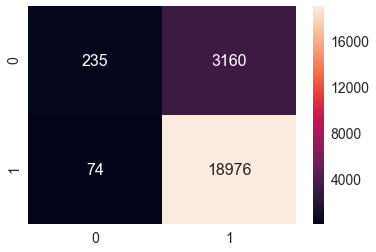

In [92]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_bow_1,y_train_1)
y_pred = knn.predict(X_train_bow_1)

cm = pd.DataFrame(confusion_matrix(y_train_1, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

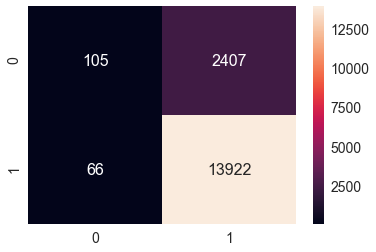

In [93]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_bow_1,y_train_1)
y_pred = knn.predict(X_test_bow_1)

cm = pd.DataFrame(confusion_matrix(y_test_1, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> TF-IDF Featurization </h2>

<h2> Spliting The Data Into Train And Test </h2>

In [31]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

vectorizer =  TfidfVectorizer()
vectorizer.fit(X_train) 

X_train_tfidf = vectorizer.transform(X_train)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 28194) (22445,)
(11055, 28194) (11055,)
(16500, 28194) (16500,)


<h2> Applying KNN_Brute_Force </h2>

In [32]:
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(X_train_tfidf, y_train) 

KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

print(neigh.predict(X_train_tfidf))

print(neigh.predict_proba(X_train_tfidf))

[1 1 0 ... 1 1 1]
[[0.         1.        ]
 [0.33333333 0.66666667]
 [0.66666667 0.33333333]
 ...
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.33333333 0.66666667]]


<h2> Hyper Parameter Tuning (Best k) </h2>

In [33]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]} 

gsv = GridSearchCV(knn,param_grid,verbose=1)
gsv.fit(X_train_tfidf,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 13.8min finished


Best HyperParameter:  {'n_neighbors': 15}
Best Accuracy: 86.10%


<h2> Performance OF Model <h2>

<h2> Train Data </h2>

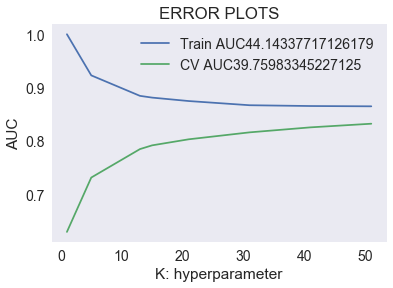

In [34]:
#take this code from assignmesnt_SAMPLE_SOLUTION

train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_tfidf, y_train)
    
    y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.axis('tight')
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

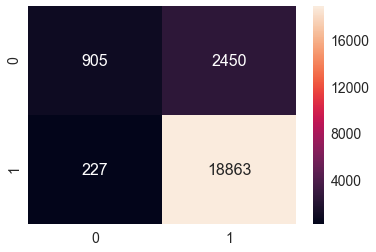

In [60]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf,y_train)
y_pred = knn.predict(X_train_tfidf)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

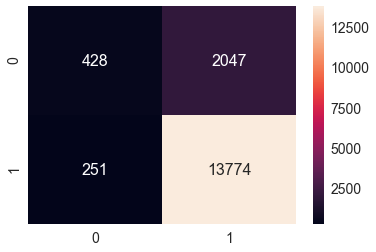

In [61]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf,y_train)
y_pred = knn.predict(X_test_tfidf)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation </h2>

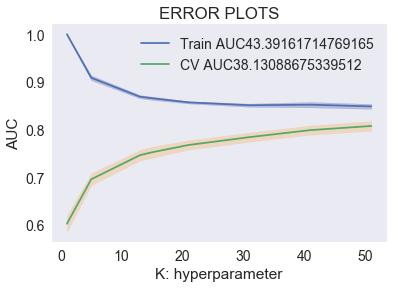

In [35]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_cv_tfidf, y_cv)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<h2> Test Data </h2>

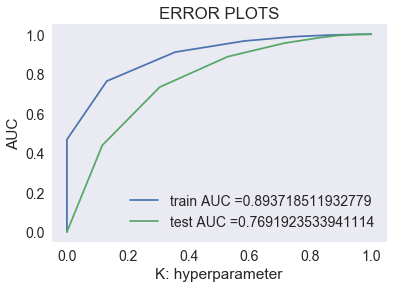

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
best_k = 15

neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_tfidf, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

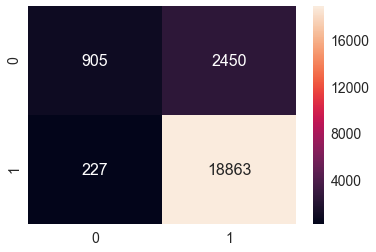

In [64]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf,y_train)
y_pred = knn.predict(X_train_tfidf)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

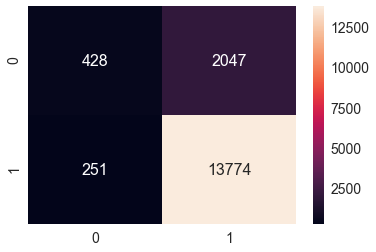

In [65]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf,y_train)
y_pred = knn.predict(X_test_tfidf)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> TF_IDF for Kd_tree </h2>

<h2> Spliting The Data into Train And Test </h2>

In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

vectorizer =  TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500 )
vectorizer.fit(X_train_1)
X_train_tfidf_1 = vectorizer.transform(X_train_1)
X_cv_tfidf_1 = vectorizer.transform(X_cv_1)
X_test_tfidf_1 = vectorizer.transform(X_test_1)

print("After vectorizations")
print(X_train_tfidf_1.shape, y_train_1.shape)
print(X_cv_tfidf_1.shape, y_cv_1.shape)
print(X_test_tfidf_1.shape, y_test_1.shape)
print("="*100)

After vectorizations
(22445, 500) (22445,)
(11055, 500) (11055,)
(16500, 500) (16500,)


<h2> Applying KNN-Kd_Tree </h2>

In [39]:
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(X_train_tfidf_1, y_train_1) 

KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

print(neigh.predict(X_train_tfidf_1))

print(neigh.predict_proba(X_train_tfidf_1))

[1 1 1 ... 0 1 1]
[[0.33333333 0.66666667]
 [0.         1.        ]
 [0.         1.        ]
 ...
 [0.66666667 0.33333333]
 [0.         1.        ]
 [0.         1.        ]]


<h2> Hyper Parameter Tuning (Best k) </h2>

In [40]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]} 
gsv = GridSearchCV(knn,param_grid,verbose=1)
gsv.fit(X_train_tfidf_1,y_train_1)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("c

Best HyperParameter:  {'n_neighbors': 15}
Best Accuracy: 85.37%


<h2> Performance Of Model </h2>

<h2> Train Data </h2>

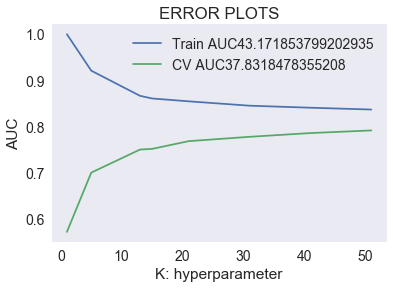

In [41]:
#take this code from assignmesnt_SAMPLE_SOLUTION
train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_tfidf_1, y_train_1)
    
    y_train_pred =  neigh.predict_proba(X_train_tfidf_1)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf_1)[:,1]
    
    train_auc.append(roc_auc_score(y_train_1,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv_1, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()

plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.axis('tight')
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

<h2> Confusion Matrix </h2>

<h2>  Test Data </h2>

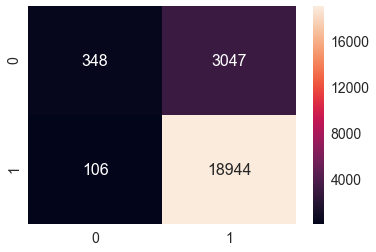

In [86]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf_1,y_train_1)
y_pred = knn.predict(X_train_tfidf_1)

cm = pd.DataFrame(confusion_matrix(y_train_1, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

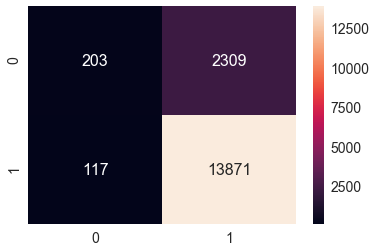

In [87]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf_1,y_train_1)
y_pred = knn.predict(X_test_tfidf_1)

cm = pd.DataFrame(confusion_matrix(y_test_1, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

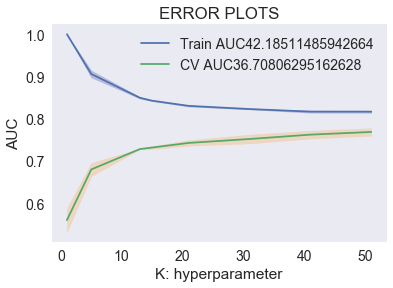

In [42]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_cv_tfidf_1, y_cv_1)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<h2> Test Data </h2>

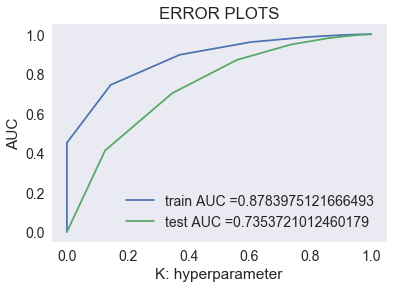

In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
best_k = 15

neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_tfidf_1, y_train_1)


train_fpr, train_tpr, thresholds = roc_curve(y_train_1, neigh.predict_proba(X_train_tfidf_1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_1, neigh.predict_proba(X_test_tfidf_1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.axis('tight')
plt.grid()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

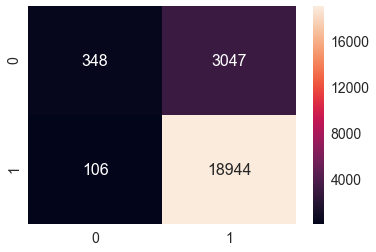

In [88]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_tfidf_1,y_train_1)
y_pred = knn.predict(X_train_tfidf_1)

cm = pd.DataFrame(confusion_matrix(y_train_1, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

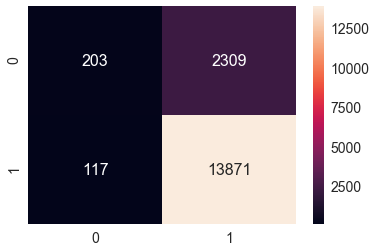

In [89]:
knn = KNeighborsClassifier(n_neighbors=15    
                             )
knn.fit(X_train_tfidf_1,y_train_1)
y_pred = knn.predict(X_test_tfidf_1)

cm = pd.DataFrame(confusion_matrix(y_test_1   , y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Word2Vec Featurization </h2>

In [44]:
nltk.download('stopwords')

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')


def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|]',r' ',cleaned)
    return cleaned

print(stop)
print('******************************************')
print(sno.stem('tasty'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'that', 'in', 'here', 'same', 'there', 'll', "aren't", "won't", 'his', 'it', 'will', 'i', 'being', 'did', 'if', "didn't", 'our', "you're", 'theirs', 'under', 'before', "should've", 'ain', 'he', 'a', 'yourselves', 'yourself', 'himself', 'are', 'and', 'over', 'other', 'wouldn', 'against', 'as', "mustn't", "don't", 'their', 'from', 'while', 'so', "it's", "hadn't", 'hasn', "haven't", 'below', 'mustn', 'any', 'been', 'haven', 'weren', 'o', 'him', 'them', 'whom', 'hadn', "weren't", 'won', 'with', 'once', 'or', 'to', 'own', 'this', 'more', 'm', 'its', 'was', 'not', 'were', 'through', 're', 'both', 'shouldn', 'between', 'again', 'about', 'only', 'hers', 'which', 'all', 'herself', 'for', 'd', 'didn', 'is', 'very', "you'd", 'then', 'what', 'should', "shouldn't", 'my', 'she', 'these', 'down', 'further', "doesn't", "you've", 'nor', 'had', 'ca

In [45]:
i=0
str1=''
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in knn_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (knn_ar['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (knn_ar['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
    str1 = b" ".join(filtered_sentence)
   # print("***********************************************************************888")
    final_string.append(str1)
    i+=1

In [46]:
knn_ar['CleanedText']=final_string

In [47]:
i=0
list_of_sent=[]
for sent in knn_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence) 

In [48]:
print(knn_ar['Text'].values[0])
print("***********************************************************************************")
print(list_of_sent[0])
# conda install gensim 

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
***********************************************************************************
['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(x, y, test_size=0.33) 
X_train_5, X_cv_5, y_train_5, y_cv_5 = train_test_split(X_train_5, y_train_5, test_size=0.33) 


print(X_train_5.shape, y_train_5.shape)
print(X_cv_5.shape, y_cv_5.shape)
print(X_test_5.shape, y_test_5.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) 
X_train_bow_2= vectorizer.transform(X_train_5)
X_cv_bow_2 = vectorizer.transform(X_cv_5)
X_test_bow_2 = vectorizer.transform(X_test_5)

print("After vectorizations")
print(X_train_bow_2.shape, y_train_5.shape)
print(X_cv_bow_2.shape, y_cv_5.shape)
print(X_test_bow_2.shape, y_test_5.shape)
print("="*100)

(22445,) (22445,)
(11055,) (11055,)
(16500,) (16500,)
After vectorizations
(22445, 28194) (22445,)
(11055, 28194) (11055,)
(16500, 28194) (16500,)


<h2> Word2Vec featurezation In Train Data </h2>

In [50]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [51]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [52]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16006
sample words  ['This', 'is', 'a', 'great', 'blend.', 'And', "you'll", 'enjoy', 'the', 'last', 'bag', 'just', 'as', 'much', 'first', 'because,', 'unlike', 'some', 'each', 'sealed', 'in', 'foil', 'packet', 'that', 'keeps', 'it', 'fresh', 'forever.', 'These', 'oatmeal', 'raisin', 'bars', 'are', 'to', 'be', 'healthy', 'nutrition', 'bars.', 'There', 'really', 'nothing', 'or', 'nutritious', 'about', 'these', '"Eat', 'Think', 'They', 'high', 'calories']


<h2> For Train Data </h2>

In [53]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 22445/22445 [03:02<00:00, 122.81it/s]


(22445, 50)
[-0.90640726 -0.32179102  0.43881198  0.08308839 -0.24395809  1.04190092
 -0.78530156  0.60993944  0.05788416 -0.02312035  0.33812081  0.44612876
  0.24596414 -0.70300117 -0.44504698 -0.7694068  -0.12083252  0.34754905
 -0.12905529 -0.55048319  0.52717407 -0.32371353 -0.37327614  0.10816008
 -0.07084207  0.443973    0.65165913 -0.47206348  0.49900673 -0.36439033
  0.37231644 -0.55509848  0.17666747 -0.60734484  0.33138377  0.00313668
 -0.49816532 -0.64048613  0.15726147 -1.07325611  0.45482155  0.03702925
 -0.13363247  0.17295473  0.62912674  0.28829265 -0.07902373  0.88217503
 -0.73661251 -0.6192496 ]


<h2> For Cross-Validation Data </h2>

In [54]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [55]:
# average Word2Vec
# compute average word2vec for each review.i=0
list_of_sentance_cv=[]
for sentance in X_cv_5:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 11055/11055 [01:45<00:00, 104.62it/s]


(11055, 50)
[-8.91630378e-01 -5.14904773e-02  1.97948777e-01 -1.10465744e-01
 -1.54331778e-01  9.50627770e-01 -4.31141656e-01  5.31506677e-01
 -3.35141343e-02 -3.96890018e-01  6.53602725e-02  5.72811251e-01
  1.99448012e-01 -6.79494601e-01 -3.92620705e-01 -6.41872613e-01
 -4.33852933e-02  7.84314902e-01  2.02331995e-01 -4.29945341e-01
  5.15528604e-01 -3.23980699e-01  2.30035631e-01  2.85478079e-01
 -3.96570793e-02 -5.92748846e-02  8.37446160e-02 -3.87777580e-01
  6.33475254e-01 -2.56106396e-01 -2.17818738e-02 -4.51374166e-01
  2.75526358e-01 -3.07035451e-01  1.12457388e-02  6.07745867e-02
 -3.91273371e-01 -6.71292652e-01  7.38666992e-02 -3.85971044e-01
 -4.86026169e-02  5.74927832e-01 -1.95225969e-01 -5.59423068e-04
  2.25243664e-01  1.76351126e-01  8.61617663e-02  2.54623597e-01
 -2.90789408e-01 -6.06123631e-01]


<h2> For Test Data <h2>

In [56]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [57]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 16500/16500 [03:04<00:00, 89.37it/s]


(16500, 50)
[-0.37862261  0.16812492  0.31426787 -0.11515321 -0.15818251  1.16575232
 -0.2197837   0.76355354  0.2070989  -0.36501947  0.86532484  0.16819284
  0.02794183 -0.22113917 -0.88839152 -0.12286184  0.45514075  0.2639585
  0.07720056 -0.28459555  1.09492294 -0.00914305 -0.16015781 -0.0222077
  0.1208615   0.59085778  0.04189205 -0.54428066  0.57562102  0.16686403
  0.26435249 -0.23464877  0.22114831 -0.43638397  0.09241709 -0.16125387
  0.01591919 -0.17376278  0.1840858  -0.79199712  0.05607539 -0.05355851
 -0.23632851  0.02963618  0.70130948 -0.72422068  0.11471713  0.57689767
 -0.60967981 -0.61561024]


<h2> Applying KNN-BruteForce </h2>

In [58]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(sent_vectors_train, y_train) 

KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

print(neigh.predict(sent_vectors_train))

print(neigh.predict_proba(sent_vectors_train))

[1 1 1 ... 1 1 1]
[[0.         1.        ]
 [0.33333333 0.66666667]
 [0.         1.        ]
 ...
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.         1.        ]]


<h2> Hyper Parameter Tuning (Best K) </h2>

In [62]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(algorithm='brute')

param_grid = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]} 

gsv = GridSearchCV(knn,param_grid,verbose=1)
gsv.fit(sent_vectors_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  5.5min finished


Best HyperParameter:  {'n_neighbors': 31}
Best Accuracy: 85.40%


<h2> Applying KNN-K_Tree  </h2>

In [63]:
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(sent_vectors_train, y_train) 

KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

print(neigh.predict(sent_vectors_train))

print(neigh.predict_proba(sent_vectors_train))

[1 1 1 ... 1 1 1]
[[0.         1.        ]
 [0.33333333 0.66666667]
 [0.         1.        ]
 ...
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.         1.        ]]


<h2> Hyper-Parameter Tuning (Best K) </h2>

In [64]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]} 
gsv = GridSearchCV(knn,param_grid,verbose=1)
gsv.fit(sent_vectors_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 22.0min finished


Best HyperParameter:  {'n_neighbors': 31}
Best Accuracy: 85.40%


<h2> Performance Of Model </h2>

<h2> Train Data </h2>

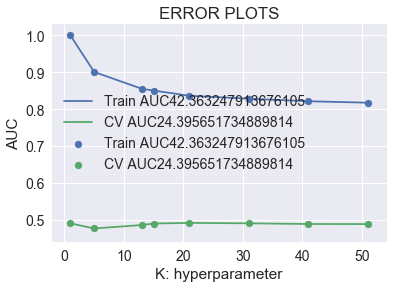

In [65]:
train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.scatter(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.scatter(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)




<h2> Confusion Matrix </h2>

<h2> TRain Data </h2>

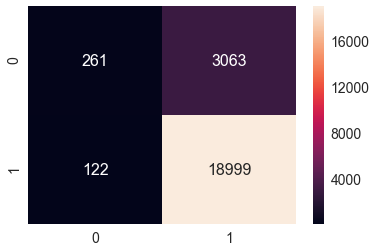

In [82]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(sent_vectors_train,y_train)
y_pred = knn.predict(sent_vectors_train)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

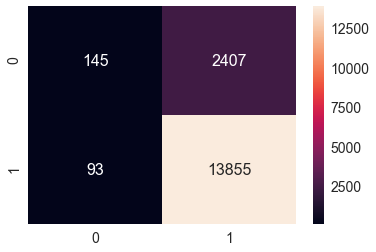

In [83]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(sent_vectors_train,y_train)
y_pred = knn.predict(sent_vectors_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

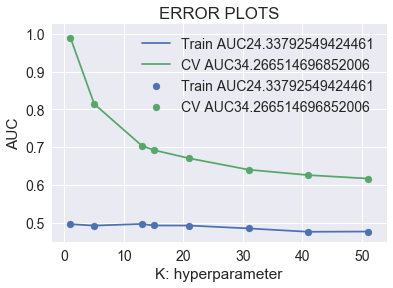

In [66]:
train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(sent_vectors_cv, y_cv)
   
    y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.scatter(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.scatter(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)




<h2> Test Data </h2>

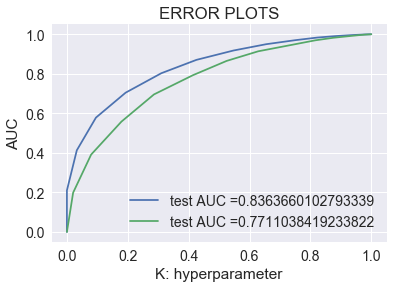

In [67]:
neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(sent_vectors_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="test AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)



<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

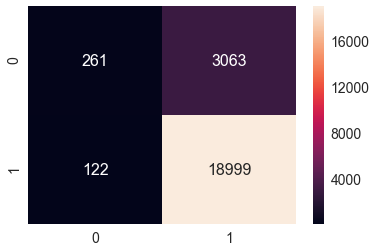

In [84]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(sent_vectors_train,y_train)
y_pred = knn.predict(sent_vectors_train)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

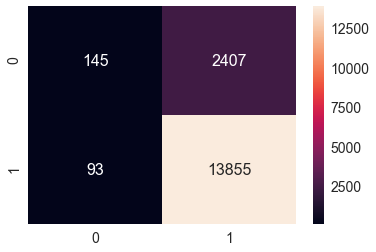

In [85]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(sent_vectors_train,y_train)
y_pred = knn.predict(sent_vectors_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Avg Word2Vec </h2>

<h2> For Train Data </h2>

In [68]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(knn_ar['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_train = [];  
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_train = np.array(sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 22445/22445 [20:40<00:00, 18.09it/s]


(22445, 50)
[-0.90640726 -0.32179102  0.43881198  0.08308839 -0.24395809  1.04190092
 -0.78530156  0.60993944  0.05788416 -0.02312035  0.33812081  0.44612876
  0.24596414 -0.70300117 -0.44504698 -0.7694068  -0.12083252  0.34754905
 -0.12905529 -0.55048319  0.52717407 -0.32371353 -0.37327614  0.10816008
 -0.07084207  0.443973    0.65165913 -0.47206348  0.49900673 -0.36439033
  0.37231644 -0.55509848  0.17666747 -0.60734484  0.33138377  0.00313668
 -0.49816532 -0.64048613  0.15726147 -1.07325611  0.45482155  0.03702925
 -0.13363247  0.17295473  0.62912674  0.28829265 -0.07902373  0.88217503
 -0.73661251 -0.6192496 ]


<h2>For Cross-Validation Data </h2>

In [69]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(knn_ar['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_cv = [];
row=0;
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])   

100%|████████████████████████████████████████████████████████████████████████████| 11055/11055 [10:22<00:00, 17.77it/s]


(11055, 50)
[-8.91630378e-01 -5.14904773e-02  1.97948777e-01 -1.10465744e-01
 -1.54331778e-01  9.50627770e-01 -4.31141656e-01  5.31506677e-01
 -3.35141343e-02 -3.96890018e-01  6.53602725e-02  5.72811251e-01
  1.99448012e-01 -6.79494601e-01 -3.92620705e-01 -6.41872613e-01
 -4.33852933e-02  7.84314902e-01  2.02331995e-01 -4.29945341e-01
  5.15528604e-01 -3.23980699e-01  2.30035631e-01  2.85478079e-01
 -3.96570793e-02 -5.92748846e-02  8.37446160e-02 -3.87777580e-01
  6.33475254e-01 -2.56106396e-01 -2.17818738e-02 -4.51374166e-01
  2.75526358e-01 -3.07035451e-01  1.12457388e-02  6.07745867e-02
 -3.91273371e-01 -6.71292652e-01  7.38666992e-02 -3.85971044e-01
 -4.86026169e-02  5.74927832e-01 -1.95225969e-01 -5.59423068e-04
  2.25243664e-01  1.76351126e-01  8.61617663e-02  2.54623597e-01
 -2.90789408e-01 -6.06123631e-01]


<h2> For Test Data </h2>

In [70]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(knn_ar['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

tfidf_sent_vectors_test = np.array(sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 16500/16500 [15:57<00:00, 18.26it/s]


(16500, 50)
[-0.37862261  0.16812492  0.31426787 -0.11515321 -0.15818251  1.16575232
 -0.2197837   0.76355354  0.2070989  -0.36501947  0.86532484  0.16819284
  0.02794183 -0.22113917 -0.88839152 -0.12286184  0.45514075  0.2639585
  0.07720056 -0.28459555  1.09492294 -0.00914305 -0.16015781 -0.0222077
  0.1208615   0.59085778  0.04189205 -0.54428066  0.57562102  0.16686403
  0.26435249 -0.23464877  0.22114831 -0.43638397  0.09241709 -0.16125387
  0.01591919 -0.17376278  0.1840858  -0.79199712  0.05607539 -0.05355851
 -0.23632851  0.02963618  0.70130948 -0.72422068  0.11471713  0.57689767
 -0.60967981 -0.61561024]


<h2> Applying KNN-BruteForce </h2>

In [71]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(tfidf_sent_vectors_train, y_train) 

KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

print(neigh.predict( tfidf_sent_vectors_train))

print(neigh.predict_proba( tfidf_sent_vectors_train))

[1 1 1 ... 1 1 1]
[[0.         1.        ]
 [0.33333333 0.66666667]
 [0.         1.        ]
 ...
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.         1.        ]]


<h2> Applying KNN-Kd_Tree </h2>

In [72]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(tfidf_sent_vectors_train, y_train) 

KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

print(neigh.predict(tfidf_sent_vectors_train))

print(neigh.predict_proba(tfidf_sent_vectors_train))

[1 1 1 ... 1 1 1]
[[0.         1.        ]
 [0.33333333 0.66666667]
 [0.         1.        ]
 ...
 [0.33333333 0.66666667]
 [0.         1.        ]
 [0.         1.        ]]


<h2> Hyper-Parameter Tuning (Best K) </h2>

In [73]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto')

param_grid = {'n_neighbors':[1, 5, 13, 15, 21, 31, 41, 51]} 
gsv = GridSearchCV(knn,param_grid,verbose=1)
gsv.fit(sent_vectors_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 21.9min finished


Best HyperParameter:  {'n_neighbors': 31}
Best Accuracy: 85.40%


<h2> Performance Of Model </h2>

<h2> Train Data </h2>

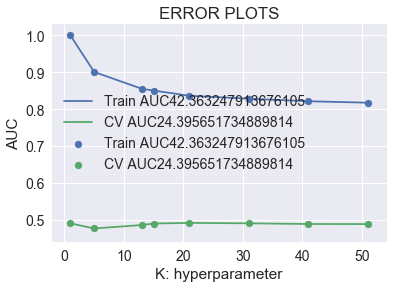

In [74]:
train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.scatter(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.scatter(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)




<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

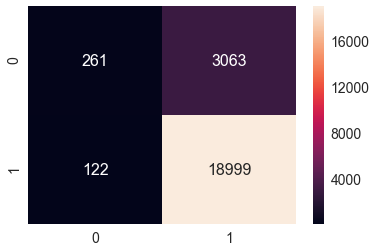

In [80]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(tfidf_sent_vectors_train,y_train)
y_pred = knn.predict(tfidf_sent_vectors_train)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

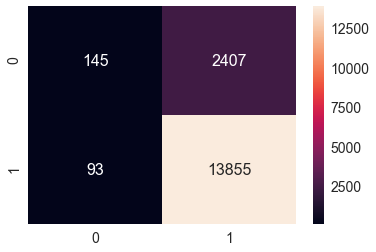

In [81]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(tfidf_sent_vectors_train,y_train)
y_pred = knn.predict(tfidf_sent_vectors_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Cross-Validation Data </h2>

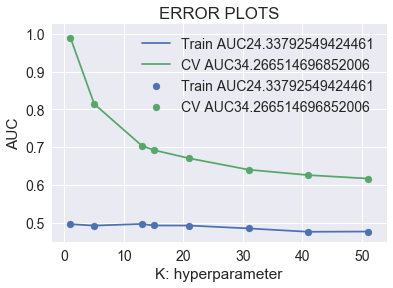

In [75]:
train_auc = []
cv_auc = []
K = [1, 5, 13, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(tfidf_sent_vectors_cv, y_cv)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.scatter(K, train_auc, label='Train AUC'+str(auc(K, train_auc)))
plt.plot(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.scatter(K, cv_auc, label='CV AUC'+str(auc(K, cv_auc)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()




<h2> Test Data </h2>

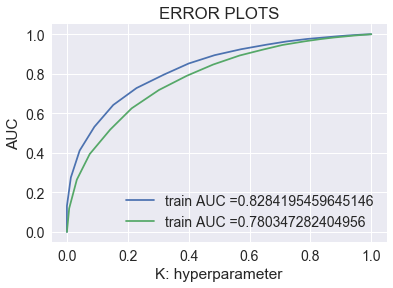

In [77]:
neigh = KNeighborsClassifier(n_neighbors=31)
neigh.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)



<h2> Confusion Matrix </h2>

<h2> Train Data </h2>

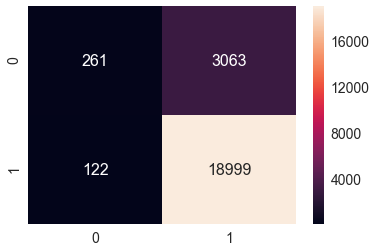

In [78]:
#https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(tfidf_sent_vectors_train,y_train)
y_pred = knn.predict(tfidf_sent_vectors_train)

cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Test Data </h2>

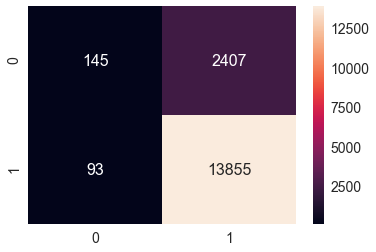

In [79]:
knn = KNeighborsClassifier(n_neighbors=31)
knn.fit(tfidf_sent_vectors_train,y_train)
y_pred = knn.predict(tfidf_sent_vectors_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h2> Conclusion Table </h2>

In [98]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Set", "Vectorizer", "Model 1", "Hyper Parameter", "Train_AUC", "Test_AUC"]

x.add_row(["Set:-1", "BOW", "KNN_knn_brute", 13, 42.46, 0.71])
x.add_row(["Set:-2", "TFIDF", "KNN_brute", 15, 41.68, 0.72])
x.add_row(["Set:-3", "BOW", "KNN_kd_tree", 15, 44.14, 0.76])
x.add_row(["Set:-4", "TFIDF", "KNN_kd_tree", 15, 43.17, 0.73])
x.add_row(["Set:-6", "W2V", "KNN", 31, 42.36, 0.77])
x.add_row(["Set:-8", "TFIDFW2V", "KNN", 31, 42.36, 0.78])

print(x)

+--------+------------+---------------+-----------------+-----------+----------+
|  Set   | Vectorizer |    Model 1    | Hyper Parameter | Train_AUC | Test_AUC |
+--------+------------+---------------+-----------------+-----------+----------+
| Set:-1 |    BOW     | KNN_knn_brute |        13       |   42.46   |   0.71   |
| Set:-2 |   TFIDF    |   KNN_brute   |        15       |   41.68   |   0.72   |
| Set:-3 |    BOW     |  KNN_kd_tree  |        15       |   44.14   |   0.76   |
| Set:-4 |   TFIDF    |  KNN_kd_tree  |        15       |   43.17   |   0.73   |
| Set:-6 |    W2V     |      KNN      |        31       |   42.36   |   0.77   |
| Set:-8 |  TFIDFW2V  |      KNN      |        31       |   42.36   |   0.78   |
+--------+------------+---------------+-----------------+-----------+----------+


<h2>========================================================================= </h2>